In [1]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from EduCDM import EMDINA as DINA

In [2]:
# MPSでサポートしていない演算を実行する際に、CPUにフォールバックするように設定
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
# elif use_mps:
#     device = torch.device("mps")
else:
    device = torch.device("cpu")
    
print(f"CUDA available: {use_cuda}")
print(f"MPS available: {use_mps}")
print(f"Using device: {device}")

CUDA available: False
MPS available: True
Using device: cpu


In [3]:
def set_seed(seed):
    random.seed(seed)  # Pythonのrandomモジュールのシードを固定
    np.random.seed(seed)  # NumPyのシードを固定
    torch.manual_seed(seed)  # PyTorchのCPUシードを固定
    torch.cuda.manual_seed(seed)  # PyTorchのGPUシードを固定
    torch.cuda.manual_seed_all(seed)  # マルチGPU環境でのシード固定
    torch.backends.cudnn.deterministic = True  # 再現性のためにCuDNNを固定
    torch.backends.cudnn.benchmark = False  # 再現性のためにCuDNNベンチマークをOFF

seed = 1
set_seed(seed)

## 実データ(EdNet)

### 演習データ読み込み

In [4]:
# user_question.csv ファイルを読み込み
"""
question_id,users
ex:q3628,"u20746,u21660,u20556,u21202,u21240"
"""
question_users = pd.read_csv("question_user.csv")

# 解かれている問題が多い順に並べ替え
# "users" カラムに split を適用してリストに変換
question_users["users"] = question_users["users"].apply(lambda x: x.split(","))

# 各質問に対するユーザー数を計算
question_users["user_count"] = question_users["users"].apply(len)

# user_count を基準に降順で並べ替え
question_users = question_users.sort_values(by="user_count", ascending=False)

print(question_users.head())

    question_id                                              users  user_count
926       q8098  [u145488, u50282, u61533, u11235, u237242, u92...      232037
489       q8074  [u50282, u61533, u11235, u237242, u92681, u220...      228334
397        q176  [u50282, u263254, u61533, u11235, u237242, u22...      227029
927       q1279  [u50282, u61533, u11235, u237242, u351207, u22...      203468
940       q6185  [u50282, u263254, u61533, u11235, u237242, u36...      191156


In [5]:
# topk 個の質問に回答している学生のみを抽出
topk = 10
top_questions = question_users["question_id"].head(topk).tolist()

# topk の質問に関連付けられたユーザーを絞り込み
if top_questions:
    # 対応するユーザーを取得し、セットとして管理
    common_users = set.intersection(
        *(
            set(question_users.loc[question_users["question_id"] == question, "users"].iloc[0])
            for question in top_questions
        )
    )
else:
    common_users = set()

# ユーザーのリストをソート
common_users = sorted(common_users)

# 結果を出力
print(f"Top {topk} questions: {top_questions}")
print(f"Number of common users: {len(common_users)}")
print(f"Common users: {list(common_users)[:10]}")

Top 10 questions: ['q8098', 'q8074', 'q176', 'q1279', 'q6185', 'q6243', 'q2068', 'q2067', 'q2069', 'q4178']
Number of common users: 158607
Common users: ['u100001', 'u100002', 'u100003', 'u100004', 'u100005', 'u100007', 'u100008', 'u100009', 'u100010', 'u100011']


### Q行列の作成

In [6]:
# questions.csv から該当するtagsを取得
questions_file_path = 'questions.csv'
questions_df = pd.read_csv(questions_file_path)

# top_questions に対応するデータを抽出
filtered_questions = questions_df[questions_df["question_id"].isin(top_questions)]

# 対応表の作成。問題にスキルを紐づける
question_tag_mapping = filtered_questions[["question_id", "tags"]]
question_tag_mapping = question_tag_mapping.copy()
question_tag_mapping["tags"] = question_tag_mapping["tags"].apply(lambda x: x.split(";"))

# スキルと問題の行と列のインデックスを定義
all_tags = [tag for tags in question_tag_mapping["tags"] for tag in tags]
unique_tags = set(all_tags)
unique_tags = sorted(unique_tags)
question_index_mapping = {qid: idx for idx, qid in enumerate(top_questions)} # 回答者が多い順になっている
tag_index_mapping = {tag: idx for idx, tag in enumerate(unique_tags)} # スキルの番号順

# Q行列を作成
Q_matrix = np.zeros((len(top_questions), len(unique_tags)), dtype=int)
for _, row in question_tag_mapping.iterrows():
    question_id = row["question_id"]
    if question_id in question_index_mapping:  # top_questions に存在する場合のみ処理
        question_idx = question_index_mapping[question_id]
        for tag in row["tags"]:
            if tag in tag_index_mapping:
                tag_idx = tag_index_mapping[tag]
                Q_matrix[question_idx, tag_idx] = 1

print(f"Unique tags: {unique_tags}")
print(f"問題×スキル: {len(Q_matrix)}×{len(unique_tags)}")
print(Q_matrix)
# print(question_tag_mapping)

Unique tags: ['100', '11', '145', '179', '182', '183', '184', '2', '24', '26', '5', '52', '55', '6', '7', '75']
問題×スキル: 10×16
[[0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


### 2回分のテストを作成

In [7]:
# ユーザーそれぞれの演習ファイル
folder_path = "KT1"

# 正誤結果を記録するリスト
R = []
R2 = []

max_users = 500
count_users = 0

n_questions = len(top_questions)

# 該当学生のファイルのみ処理
for user_id in tqdm(common_users):
    file_path = os.path.join(folder_path, f"{user_id}.csv")
    
    if os.path.isfile(file_path):
        user_df = pd.read_csv(file_path)
        
        # 前後半に分割
        mid_index = len(user_df) // 2
        first_half = user_df.iloc[:mid_index]
        second_half = user_df.iloc[mid_index:]
        
        # 前半部分に top_questions がすべて含まれているかを判定
        questions_in_first_half = set(first_half["question_id"])
        all_included_first_half = set(top_questions).issubset(questions_in_first_half)
        # 後半部分に top_questions がすべて含まれているかを判定
        questions_in_second_half = set(second_half["question_id"])
        all_included_second_half = set(top_questions).issubset(questions_in_second_half)

        # 前後半ともに含んでいた場合
        if all_included_first_half and all_included_second_half:
            # 個人の回答結果
            R_list = [None] * n_questions
            R2_list = [None] * n_questions

            # top_questions に含まれる問題をフィルタリング
            """注意：最も直近の値が格納されている"""
            # 1回目テスト
            first_questions = first_half[first_half["question_id"].isin(top_questions)]
            # 正解判定
            for _, question_row in first_questions.iterrows():
                question_id = question_row["question_id"]
                user_answer = question_row["user_answer"]
                
                # 正解を取得
                correct_answer = questions_df.loc[questions_df["question_id"] == question_id, "correct_answer"].iloc[0]
                
                # 判定：正解なら1、不正解なら0
                is_correct = 1 if user_answer == correct_answer else 0
                
                # R の該当箇所に結果を記録
                # user_idx = user_index_mapping[user_id]  # ユーザーのインデックス
                question_idx = top_questions.index(question_id)  # 質問のインデックス
                R_list[question_idx] = is_correct
            R.append(R_list)

            # 2回目テスト
            second_questions = second_half[second_half["question_id"].isin(top_questions)]
            # 正解判定
            for _, question in second_questions.iterrows():
                question_id = question["question_id"]
                user_answer = question["user_answer"]
                
                # 正解を取得
                correct_answer = questions_df.loc[questions_df["question_id"] == question_id, "correct_answer"].iloc[0]
                
                is_correct = 1 if user_answer == correct_answer else 0

                question_idx = top_questions.index(question_id)
                R2_list[question_idx] = is_correct
            R2.append(R2_list)

R = np.array(R, dtype=float)
R2 = np.array(R2, dtype=float)
np.save("R.npy", R)
np.save("R2.npy", R2)

100%|██████████| 158607/158607 [51:30<00:00, 51.32it/s]   


In [8]:
R = np.load("R.npy")
R2 = np.load("R2.npy")

# 同期シャッフル用のインデックスを生成
shuffle_indices = np.random.permutation(R.shape[0])

# インデックスを適用してシャッフル
R = R[shuffle_indices]
R2 = R2[shuffle_indices]

# 学生数
# print(f"Number of students: {R.shape}")
# print(f"Number of students: {R2.shape}")

# **None と NaN の確認関数** 
def check_missing_values(array, name):
    # None の検出
    if np.any(array == None):  # `is None` は配列全体には使えないため `== None` を使用
        print(f"⚠️ アラート: {name} に 'None' が含まれています。")

    # NaN の検出
    if np.issubdtype(array.dtype, np.number):  # 数値型のときのみ np.isnan を使う
        if np.isnan(array).any():
            print(f"⚠️ アラート: {name} に 'NaN' が含まれています。")

# チェック実行
check_missing_values(R, "R")
check_missing_values(R2, "R2")

In [9]:
# # NumPy 配列の全表示設定
np.set_printoptions(threshold=np.inf)

# 結果を表示
print("R matrix:")
print(R.shape)
print(R[:3])

print("R2 matrix:")
print(R2.shape)
print(R2[:3])

diff = R2-R

# 1 の数をカウント
count_1 = np.count_nonzero(diff == 1)
# -1 の数をカウント
count_minus_1 = np.count_nonzero(diff == -1)

print(f"新たに正解した数: {count_1}")
print(f"新たに間違えた数: {count_minus_1}")

R matrix:
(283, 10)
[[1. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 1. 1. 1. 1. 0.]]
R2 matrix:
(283, 10)
[[1. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 0. 0. 0.]]
新たに正解した数: 598
新たに間違えた数: 319


## CDM（認知診断モデル）

In [10]:
# ファイルを設定
CDM_dir = "./EdNet_CDM"
os.makedirs(CDM_dir, exist_ok=True)


### 1回目習得スキル

In [11]:
# データの形状取得
stu_num, prob_num = R.shape
_, know_num = Q_matrix.shape

# ログレベルを設定
logging.getLogger().setLevel(logging.INFO)

# DINAモデルの初期化
cdm = DINA(R, Q_matrix, stu_num, prob_num, know_num, skip_value=-1)# モデルの訓練

cdm.train(epoch=10, epsilon=1e-3)  # epochやepsilonは調整可能

# 訓練済みモデルの保存
CDM_path = os.path.join(CDM_dir, 'EdNet_dina_model.params')
cdm.save(CDM_path)

# モデルの評価 (RMSE, MAE)
rmse, mae = cdm.eval([{'user_id': i, 'item_id': j, 'score': R[i, j]}
                      for i in range(stu_num) for j in range(prob_num) if R[i, j] != -1])
print("RMSE: %.6f, MAE: %.6f" % (rmse, mae))


INFO:root:save parameters to ./EdNet_CDM/EdNet_dina_model.params
evaluating: 100%|██████████| 2830/2830 [00:00<00:00, 1861649.99it/s]

RMSE: 0.305491, MAE: 0.206669


### 2回目習得スキル

In [12]:
# データの形状取得
stu_num, prob_num = R2.shape
_, know_num = Q_matrix.shape

# ログレベルを設定
logging.getLogger().setLevel(logging.INFO)

# DINAモデルの初期化
cdm2 = DINA(R2, Q_matrix, stu_num, prob_num, know_num, skip_value=-1)# モデルの訓練

cdm2.train(epoch=10, epsilon=1e-3)  # epochやepsilonは調整可能

# 訓練済みモデルの保存
CDM_path2 = os.path.join(CDM_dir, 'EdNet_dina_model_2.params')
cdm2.save(CDM_path2)

# モデルの評価 (RMSE, MAE)
rmse, mae = cdm.eval([{'user_id': i, 'item_id': j, 'score': R2[i, j]}
                      for i in range(stu_num) for j in range(prob_num) if R2[i, j] != -1])
print("RMSE: %.6f, MAE: %.6f" % (rmse, mae))

INFO:root:save parameters to ./EdNet_CDM/EdNet_dina_model_2.params
evaluating: 100%|██████████| 2830/2830 [00:00<00:00, 1840291.52it/s]

RMSE: 0.489786, MAE: 0.353234


### 習得スキル

In [13]:
# 学習済みモデルのパラメータをロード
CDM_path = os.path.join(CDM_dir, 'EdNet_dina_model.params')
cdm.load(CDM_path)

attributes = []
# 学生ごとのアトリビュート（知識状態）を取得
for stu_id in range(cdm.stu_num):
    # 学生の状態IDを取得
    state_id = cdm.theta[stu_id]
    # 状態IDに対応する知識状態（バイナリベクトル）
    knowledge_state = cdm.all_states[state_id]
    attributes.append(knowledge_state)
    # print(f"Student {stu_id}: State ID = {state_id}, Knowledge State = {knowledge_state}")

attributes = np.array(attributes)

INFO:root:load parameters from ./EdNet_CDM/EdNet_dina_model.params


In [14]:
# 学習済みモデルのパラメータをロード
CDM_path2 = os.path.join(CDM_dir, 'EdNet_dina_model_2.params')
cdm2.load(CDM_path2)

attributes2 = []
# 学生ごとのアトリビュート（知識状態）を取得
for stu_id in range(cdm2.stu_num):
    # 学生の状態IDを取得
    state_id = cdm2.theta[stu_id]
    # 状態IDに対応する知識状態（バイナリベクトル）
    knowledge_state = cdm2.all_states[state_id]
    attributes2.append(knowledge_state)
    # print(f"Student {stu_id}: State ID = {state_id}, Knowledge State = {knowledge_state}")

attributes2 = np.array(attributes2)

INFO:root:load parameters from ./EdNet_CDM/EdNet_dina_model_2.params


In [15]:
attributes_diff = attributes2 - attributes
# 1 の数をカウント
count_1 = np.count_nonzero(attributes_diff == 1)
# -1 の数をカウント
count_minus_1 = np.count_nonzero(attributes_diff == -1)

print(f"新たに習得した数: {count_1}")
print(f"新たに失った数: {count_minus_1}")

新たに習得した数: 815
新たに失った数: 374


In [16]:
# 学習者は1度習得したスキルは失わないと仮定
# 要素ごとのOR演算
attributes1or2 = np.logical_or(attributes2, attributes).astype(int)
get_attributes = attributes1or2 - np.array(attributes)
print(get_attributes[:3])
print(attributes[:3])
print(len(get_attributes))

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.]]
283


## モデル

### アーキテクチャ

In [17]:
def _bcsoftmax1d_stable(x, budget):
    """Budget Constrained Softmax function for vector.
    This function is more numerically stable than `_bcsoftmax1d` by computing some values in log-scale.
    
    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    # sorting
    _, indices = torch.sort(torch.log(budget) - x, descending=False)
    x = x[indices]
    budget = budget[indices]
    # find K_B
    log_r = torch.flip(torch.logcumsumexp(torch.flip(x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    is_in_KB = torch.logical_or(
        budget == 0,
        torch.logical_and(
            s - budget > 0,
            x - log_r + torch.log(s) > torch.log(budget)
        )
    )
    # compute outputs
    exp_x = torch.exp(x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0])
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


class BCSoftmax1d(torch.autograd.Function):
    """Autograd implementation of Budget Constrained Softmax function for vector.
    """
    generate_vmap_rule = True
    
    @staticmethod
    def forward(x, c):
        y = _bcsoftmax1d_stable(x, c)
        return y

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, c = inputs
        is_in_KB = c == output
        ctx.save_for_backward(x, c, is_in_KB)
    
    @staticmethod
    def backward(ctx, grad_y):
        x, c, is_in_KB = ctx.saved_tensors
        exp_x = torch.exp(
            x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0]
        )
        s = 1 - torch.sum(c * is_in_KB)
        r = torch.sum(exp_x * (~is_in_KB))
        
        # compute Jacobian
        Jx = torch.where(
            torch.outer(~is_in_KB, ~is_in_KB),
            torch.diag(~is_in_KB * exp_x) * r - torch.outer(exp_x, exp_x),
            0,
        )
        Jx *= torch.where(
            s > 0,
            s / (r * r),
            0
        )
        Jc = torch.where(
            torch.outer(~is_in_KB, is_in_KB),
            - exp_x[:, None] / r,
            1.0 * torch.diag(is_in_KB)
        )

        # return vector-Jacobian product
        return torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc)

In [18]:
bcsoftmax1d = BCSoftmax1d.apply
# バッチを処理するとき
# bcsoftmax2d = torch.vmap(BCSoftmax1d.apply) # input shape = (batch_size, n_classes)

class Model(nn.Module):
    def __init__(self, n_skills):
        super(Model, self).__init__()
        self.fc = nn.Linear(n_skills, n_skills)  # 全結合層

    def forward(self, x, c):
        x = self.fc(x)  # 全結合層の適用
        x = bcsoftmax1d(x, c)
        return x

### 学習・評価

In [19]:
def l1(model):
    l1_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.sum(torch.abs(param))
    return l1_reg

def l2(model):
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        l2_reg = l2_reg + torch.sum(torch.pow(param, 2))
    return l2_reg

def train(model, n_skills, device, X_train, y_val, criterion, optimizer, hyp, reg):
    model.train()

    outputs = []
    relu = nn.ReLU()
    # データによってループ回数が異なる
    for i, target in enumerate(y_val):
        # 初期budget
        c = torch.ones(n_skills, dtype=torch.float32, device=device)
        c = c - X_train[i]
        state = X_train[i].to(device) # .to(device)は新しいテンソルを返す処理だから.clone()は不要

        # 習得数だけループ
        for _ in range(int(sum(target))):
            # もしcの和が1なら、rが0となってしまう
            if c.sum() <= 1:
                prob = c
            else:
                prob = model(state, c)  # 状態から遷移確率を計算
            state = prob + state  # 状態の更新
            c = relu(c - prob)  # budgetの更新

        outputs.append(state - X_train[i])  # 最終的な出力を保存
    
    outputs = torch.stack(outputs) # 全て合わせる

    # 正則化項
    loss_o = criterion(outputs, y_val)
    if reg == 'L1':
        loss = loss_o + hyp * l1(model)
    elif reg == 'L2':
        loss = loss_o + hyp * l2(model)
    else:
        loss = loss_o

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return float(loss)

def val_loss(model, n_skills, device, X_val, y_val, criterion, hyp, reg):
    model.eval()
    relu = nn.ReLU()

    with torch.no_grad():
        val_outputs = []
        for i, target in enumerate(y_val):
            c = torch.ones(n_skills, dtype=torch.float32, device=device)
            c = c - X_val[i]
            state = X_val[i].to(device)

            # 習得数だけループ
            for _ in range(int(sum(target))):
                # もしcの和が1なら、rが0となってしまう
                if c.sum() <= 1:
                    prob = c
                else:
                    prob = model(state, c)  # 状態から遷移確率を計算
                state = prob + state  # 状態の更新
                c = relu(c - prob)  # 予算の更新

            val_outputs.append(state - X_val[i])

        val_outputs = torch.stack(val_outputs)

        # 正則化項
        loss_o = criterion(val_outputs, y_val)
        if reg == 'L1':
            loss = loss_o + hyp * l1(model)
        elif reg == 'L2':
            loss = loss_o + hyp * l2(model)
        else:
            loss = loss_o

    return float(loss)

def train_model(args, n_skills, model, X_train, y_train, X_val, y_val, criterion, optimizer):
    # 試行ごとのロスを記録
    training_losses = []
    validation_losses = []
    # ロスの初期化
    best_loss = float('inf')
    count = 0 # 早期終了のカウント
    for epoch in range(args.epochs):
        train_loss = train(model, n_skills, device, X_train, y_train, criterion, optimizer, args.hyperparameter, args.Regularization)
        valid_loss = val_loss(model, n_skills, device, X_val, y_val, criterion, args.hyperparameter, args.Regularization)
        best_loss = min(best_loss, valid_loss)
        
        training_losses.append(train_loss)
        validation_losses.append(valid_loss)

        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}')

        if best_loss < valid_loss:
            count += 1
        else:
            count = 0
            # torch.save(model.state_dict(), f"{model}_{args}.pth") # モデルの保存
            
        if count >= args.early_stopping:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Best validation loss: {best_loss:.4f}")
    return training_losses, validation_losses

### データ分割

In [20]:
# データをトレーニングと検証に分割（正解数のバランスが良くなるように分割）
# 7:3に分割
def split_balanced_data(train_X, train_Y, ratio=0.7):
    data_per_correct_count = defaultdict(list)
    for x, y in zip(train_X, train_Y):
        correct_count = sum(y)
        data_per_correct_count[correct_count].append((x, y))

    X_train, y_train, X_val, y_val = [], [], [], []
    for correct_count, data in data_per_correct_count.items():
        split_index = int(len(data) * ratio)
        train_data = data[:split_index]
        val_data = data[split_index:]
        X_train.extend([x for x, _ in train_data])
        y_train.extend([y for _, y in train_data])
        X_val.extend([x for x, _ in val_data])
        y_val.extend([y for _, y in val_data])
    return X_train, y_train, X_val, y_val

## 実験

### 設定

In [21]:
import argparse

parser = argparse.ArgumentParser()

# 実験回数
parser.add_argument('--trials'        , type=int  , default=1    , help='number of trials')

# 学習
parser.add_argument('--epochs'        , type=int  , default=2000 , help='number of epochs')
parser.add_argument('--lr'            , type=float, default=0.001 , help='learning rate')
parser.add_argument('--early_stopping', type=int  , default=10   , help='number of epochs for early stopping')

# データ生成
parser.add_argument('--split_ratio'   , type=float, default=0.7  , help='split ratio of training and validation data')

# 正則化
parser.add_argument('--Regularization', type=str  , default='L1' , help='Regularization, L1 or L2 or None')
parser.add_argument('--hyperparameter', type=float, default=0.001, help='hyperparameter for regularization')

# テスト用のダミー引数
args, unknown = parser.parse_known_args()
print('args:', args)

args: Namespace(trials=1, epochs=2000, lr=0.001, early_stopping=10, split_ratio=0.7, Regularization='L1', hyperparameter=0.001)


In [22]:
# データの分割
# 学習用
split = 0.3
y1_data = attributes[:int(len(attributes) * split)]
y2_data = get_attributes[:int(len(get_attributes) * split)]
# print(train_data2)

# テスト用
y1_test = attributes[int(len(attributes) * split):]
y2_test = get_attributes[int(len(get_attributes) * split):]

In [23]:
n_skills = len(attributes[0])
for trial in range(args.trials):
    print(f"Trial {trial + 1}")
    set_seed(seed)

    # データ生成
    X_init = [[0] * n_skills for _ in range(len(y1_data))]
    X_data = np.array(X_init)
    print(f"X_data shape: {X_data.shape}")
    print(f"y1_data shape: {y1_data.shape}")

    y1_data = np.array(y1_data)
    y2_data = np.array(y2_data)

    "提案手法"
    set_seed(seed)
    X_train, y_train, X_val, y_val = split_balanced_data(X_data, y1_data, args.split_ratio)
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val = torch.tensor(y_val, dtype=torch.float32).to(device)
    print(f"Train data: {len(X_train)}, Validation data: {len(X_val)}")
    proposed_model = Model(n_skills).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(proposed_model.parameters(), lr=args.lr)
    t_loss, v_loss = train_model(args, n_skills, proposed_model, X_train, y_train, X_val, y_val, criterion, optimizer)

    "上限モデル"
    set_seed(seed)
    upper_X_data = np.concatenate([X_data, X_data + y1_data], axis=0)
    upper_y_data = np.concatenate([X_data + y1_data, y2_data], axis=0)
    shuffle_data = np.random.permutation(upper_X_data.shape[0])
    upper_X_data = upper_X_data[shuffle_data]
    upper_y_data = upper_y_data[shuffle_data]
    upper_train_X, upper_train_Y, upper_val_X, upper_val_Y = split_balanced_data(upper_X_data, upper_y_data, args.split_ratio)
    upper_train_X = torch.tensor(upper_train_X, dtype=torch.float32).to(device)
    upper_train_Y = torch.tensor(upper_train_Y, dtype=torch.float32).to(device)
    upper_val_X = torch.tensor(upper_val_X, dtype=torch.float32).to(device)
    upper_val_Y = torch.tensor(upper_val_Y, dtype=torch.float32).to(device)
    print(f"Train data: {len(upper_train_X)}, Validation data: {len(upper_val_X)}")
    # モデル、損失関数、最適化関数の設定
    upper_model = Model(n_skills).to(device)
    upper_criterion = nn.BCEWithLogitsLoss()
    upper_optimizer = optim.Adam(upper_model.parameters(), lr=args.lr)
    upper_t_loss, upper_v_loss = train_model(args, n_skills, upper_model, upper_train_X, upper_train_Y, upper_val_X, upper_val_Y, upper_criterion, upper_optimizer)

    seed += 1

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_63855/2162169432.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X_train = torch.tensor(X_train, dtype=torch.float32).to(device)


Trial 1
X_data shape: (84, 16)
y1_data shape: (84, 16)
Train data: 51, Validation data: 33
Epoch 100, Loss: 0.6589
Epoch 200, Loss: 0.6395
Epoch 300, Loss: 0.6322
Epoch 400, Loss: 0.6287
Epoch 500, Loss: 0.6259
Epoch 600, Loss: 0.6236
Epoch 700, Loss: 0.6218
Epoch 800, Loss: 0.6202
Epoch 900, Loss: 0.6190
Epoch 1000, Loss: 0.6179
Epoch 1100, Loss: 0.6171
Epoch 1200, Loss: 0.6164
Epoch 1300, Loss: 0.6157
Epoch 1400, Loss: 0.6151
Epoch 1500, Loss: 0.6145
Epoch 1600, Loss: 0.6140
Epoch 1700, Loss: 0.6136
Epoch 1800, Loss: 0.6132
Epoch 1900, Loss: 0.6129
Epoch 2000, Loss: 0.6126
Best validation loss: 0.5928
Train data: 110, Validation data: 58
Epoch 100, Loss: 0.6872
Epoch 200, Loss: 0.6712
Epoch 300, Loss: 0.6666
Epoch 400, Loss: 0.6644
Epoch 500, Loss: 0.6626
Epoch 600, Loss: 0.6613
Epoch 700, Loss: 0.6602
Epoch 800, Loss: 0.6593
Epoch 900, Loss: 0.6585
Epoch 1000, Loss: 0.6579
Epoch 1100, Loss: 0.6573
Epoch 1200, Loss: 0.6569
Epoch 1300, Loss: 0.6566
Epoch 1400, Loss: 0.6562
Epoch 1500,

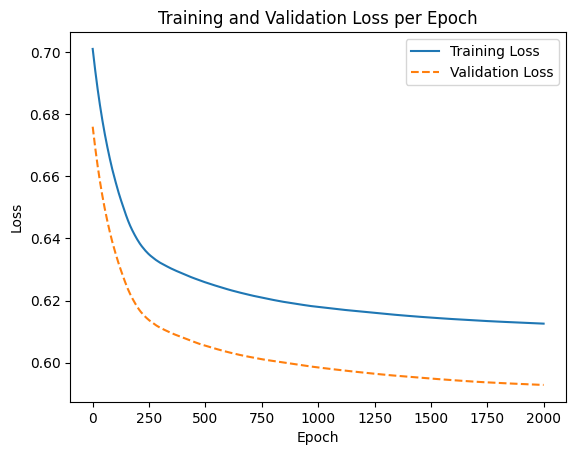

In [24]:
import matplotlib.pyplot as plt

plt.plot(t_loss, label='Training Loss')
plt.plot(v_loss, label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

### 保存先

In [25]:
save_folder = "./EdNet_model"
os.makedirs(save_folder, exist_ok=True)
# 保存用の一意な名前を作成
args_str = f"t{args.trials}_e{args.epochs}_lr{args.lr}_es{args.early_stopping}_sr{args.split_ratio}_reg{args.Regularization}_h{args.hyperparameter}"

# 保存パスを明示的に構築
proposed_save_path = os.path.join(save_folder, f"proposed_model_{args_str}_EdNet.pth")
upper_save_path = os.path.join(save_folder, f"upper_model_{args_str}_EdNet.pth")

# 保存時
torch.save(upper_model.state_dict(), upper_save_path)
torch.save(proposed_model.state_dict(), proposed_save_path)


In [26]:
n_skills = len(attributes[0])

# モデルのインスタンスを作成
upper_model = Model(n_skills)
proposed_model = Model(n_skills)

# 読み込み時
upper_model.load_state_dict(torch.load(upper_save_path))
proposed_model.load_state_dict(torch.load(proposed_save_path))

# モデルを適切なデバイスへ移動
upper_model = upper_model.to(device)
proposed_model = proposed_model.to(device)

# 推論モードに設定
upper_model.eval()
proposed_model.eval()

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_63855/4145896198.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  upper_model.load_state_dict(torch.load(upper_

Model(
  (fc): Linear(in_features=16, out_features=16, bias=True)
)

### 結果

In [27]:
def test_model(model, y1_test, y2_test):
    model.eval()
    y1_test = torch.tensor(y1_test, dtype=torch.float32).to(device)
    y2_test = torch.tensor(y2_test, dtype=torch.float32).to(device)
    relu = nn.ReLU()
    model_predict = []
    for i in range(len(y1_test)):
        c = torch.ones(n_skills, dtype=torch.float32, device=device)
        c = c - y1_test[i]
        state = y1_test[i].to(device)
        for _ in range(int(sum(y2_test[i]))):
            if c.sum() <= 1:
                prob = c
            else:
                prob = model(state, c)
            state = prob + state  # 状態の更新
            c = relu(c - prob)  # 予算の更新
        # 最終的な出力を保存
        model_predict.append((state - y1_test[i]).detach().numpy())
    model_predict = np.array(model_predict)
    return model_predict

# 提案モデルの予測
proposed_model_predict = test_model(proposed_model, y1_test, y2_test)
# 上限モデルの予測
upper_model_predict = test_model(upper_model, y1_test, y2_test)

def redistribute(p, total):
    p = np.array(p, dtype=np.float64)
    scaled = p * total
    clipped = np.minimum(scaled, 1.0)
    
    excess = total - clipped.sum()
    
    # 再分配できる要素のインデックス
    mask = clipped < 1.0
    clipped_part = clipped[mask]
    
    if excess > 0 and clipped_part.sum() > 0:
        # 比例配分で再分配
        weights = clipped_part / clipped_part.sum()
        clipped[mask] += weights * excess
        # 最大値を再度クリップ（念のため）
        clipped = np.minimum(clipped, 1.0)
    
    return clipped

# 比較手法（遷移先の分布）
com_model_predict = []
total = 0
# 状態ごとの学生数をカウント（出現回数ベース）
state_counts = defaultdict(int)
for i in range(len(y1_data)):
    state_tuple = tuple(map(int, y1_data[i]))
    state_counts[state_tuple] += 1
for i in range(len(y1_test)):
    next_prob = np.zeros(n_skills)
    total = 0
    if sum(y2_test[i]) == 0:
        com_model_predict.append(next_prob)
        continue
    for j in range(n_skills):
        if y1_test[i][j] == 0:
            next_attribute = list(y1_test[i])
            next_attribute[j] = 1
            next_attribute = tuple(next_attribute)
            next_prob[j] = state_counts[next_attribute]
            total += state_counts[next_attribute]
    if total == 0:
        mask = (y1_test[i] == 0)
        next_prob[mask] = np.sum(y1_test[i]) * (1 / np.sum(mask)) # 0部分に均等に
    else:
        next_prob = np.sum(y1_test[i]) * next_prob / total
    next_prob = redistribute(next_prob, np.sum(y2_test[i]))
    com_model_predict.append(next_prob)
com_model_predict = np.array(com_model_predict)

In [28]:
y1_data = np.array(y1_data)
difficulties = np.sum(y1_data, axis=0) 
difficulties = difficulties / difficulties.sum()  # 正規化
# print(f"難易度ベースの分布: {difficulties}")

def accuracy(model_predict, top_k):
    k = len(top_k)
    pred_top_k = set(np.argsort(model_predict)[-k:])
    return len(pred_top_k & top_k) / k

def CrossEntropy(model_predict, top_k):
    epsilon = 1e-10
    model_predict = np.where(model_predict == 0, epsilon, model_predict)
    return -np.mean(np.log(model_predict[list(top_k)]))

def d_score(model_predict, top_k, difficulties):
    score = 0
    for i in top_k:
        score += model_predict[i] / difficulties[i]
    return score / len(top_k)

def match_rate(model_predict, top_k):
    k = len(top_k)
    pred_top_k = set(np.argsort(model_predict)[-k:])
    return len(pred_top_k & top_k) / k

def AUC(model_predict, top_k, not_yet):
    auc = 0
    for skill in not_yet:
        if skill not in top_k:
            auc += 1 - model_predict[skill]
        else:
            auc += model_predict[skill]
    return auc / len(not_yet)

proposed_accuracies = []
upper_accuracies = []
step_accuracies = []
all_accuracies = []
random_accuracies = []
com_accuracies = []
difficulties_accuracies = []

proposed_scores = []
upper_proposed_scores = []
step_scores = []
all_scores = []
random_scores = []
com_scores = []
difficulties_scores = []

proposed_ce = []
upper_ce = []
step_ce = []
all_ce = []
random_ce = []
com_ce = []
difficulties_ce = []

proposed_auc = []
upper_auc = []
step_auc = []
all_auc = []
random_auc = []
com_auc = []
difficulties_auc = []

proposed_match_rate = []
upper_match_rate = []
step_match_rate = []
all_match_rate = []
for i in range(len(y2_test)):
    k = int(sum(y2_test[i]))  # 1の個数を取得（明示的に int に変換）
    if k == 0:
        continue  # 1がない場合はスキップ
    
    # 習得スキルのインデックス
    true_top_k = set(np.where(y2_test[i] == 1)[0])
    # 未習得部分
    not_yet = set(np.where(y1_test[i] == 0)[0])

    # 難易度ベース
    d_predict = np.zeros(n_skills)
    d_predict[list(not_yet)] = difficulties[list(not_yet)]
    difficulty_sum = sum(difficulties[j] for j in not_yet)
    d_predict[list(not_yet)] /= difficulty_sum
    d_predict = redistribute(d_predict, np.sum(y2_test[i]))
    d_top_k = set(np.argsort(d_predict)[-k:])
    # ランダムベース
    r_predict = np.zeros(n_skills)
    r_predict[list(not_yet)] = k / len(not_yet)

    # 予測一致率
    proposed_accuracies.append(accuracy(proposed_model_predict[i], true_top_k))
    upper_accuracies.append(accuracy(upper_model_predict[i], true_top_k))
    random_accuracies.append(len(set(np.random.choice(list(set(np.where(y1_test[i] == 0)[0])), k, replace=False)) & true_top_k) / k)
    com_accuracies.append(accuracy(com_model_predict[i], true_top_k))
    difficulties_accuracies.append(accuracy(d_predict, true_top_k))

    # 難易度スコア
    proposed_scores.append(d_score(proposed_model_predict[i], true_top_k, d_predict))
    upper_proposed_scores.append(d_score(upper_model_predict[i], true_top_k, d_predict))
    random_scores.append(d_score(r_predict, true_top_k, d_predict))
    com_scores.append(d_score(com_model_predict[i], true_top_k, d_predict))
    difficulties_scores.append(d_score(d_predict, true_top_k, d_predict))

    # クロスエントロピー
    proposed_ce.append(CrossEntropy(proposed_model_predict[i], true_top_k))
    upper_ce.append(CrossEntropy(upper_model_predict[i], true_top_k))
    random_ce.append(CrossEntropy(r_predict, true_top_k))
    com_ce.append(CrossEntropy(com_model_predict[i], true_top_k))
    difficulties_ce.append(CrossEntropy(d_predict, true_top_k))

    # AUC
    proposed_auc.append(AUC(proposed_model_predict[i], true_top_k, not_yet))
    upper_auc.append(AUC(upper_model_predict[i], true_top_k, not_yet))
    random_auc.append(AUC(r_predict, true_top_k, not_yet))
    com_auc.append(AUC(com_model_predict[i], true_top_k, not_yet))
    difficulties_auc.append(AUC(d_predict, true_top_k, not_yet))

    # 難易度ベースとの一致率
    proposed_match_rate.append(match_rate(proposed_model_predict[i], d_top_k))
    upper_match_rate.append(match_rate(upper_model_predict[i], d_top_k))

# 平均を計算（リストが空でない場合のみ）
average_proposed_accuracy = np.mean(proposed_accuracies) if proposed_accuracies else 0.0
average_upper_accuracy = np.mean(upper_accuracies) if upper_accuracies else 0.0
average_random_accuracy = np.mean(random_accuracies) if random_accuracies else 0.0
average_com_accuracy = np.mean(com_accuracies) if com_accuracies else 0.0
average_difficulties_accuracy = np.mean(difficulties_accuracies) if difficulties_accuracies else 0.0

average_proposed_score = np.mean(proposed_scores) if proposed_scores else 0.0
average_upper_proposed_score = np.mean(upper_proposed_scores) if upper_proposed_scores else 0.0
average_random_score = np.mean(random_scores) if random_scores else 0.0
average_com_score = np.mean(com_scores) if com_scores else 0.0
average_difficulties_score = np.mean(difficulties_scores) if difficulties_scores else 0.0

average_proposed_ce = np.mean(proposed_ce) if proposed_ce else 0.0
average_upper_ce = np.mean(upper_ce) if upper_ce else 0.0
average_random_ce = np.mean(random_ce) if random_ce else 0.0
average_com_ce = np.mean(com_ce) if com_ce else 0.0
average_difficulties_ce = np.mean(difficulties_ce) if difficulties_ce else 0.0

average_proposed_auc = np.mean(proposed_auc) if proposed_auc else 0.0
average_upper_auc = np.mean(upper_auc) if upper_auc else 0.0
average_random_auc = np.mean(random_auc) if random_auc else 0.0
average_com_auc = np.mean(com_auc) if com_auc else 0.0
average_difficulties_auc = np.mean(difficulties_auc) if difficulties_auc else 0.0

average_proposed_match_rate = np.mean(proposed_match_rate) if proposed_match_rate else 0.0
average_upper_match_rate = np.mean(upper_match_rate) if upper_match_rate else 0.0

print("---Accuracy---")
print(f"proposed accuracy: {average_proposed_accuracy:.4f}")
print(f"upper accuracy: {average_upper_accuracy:.4f}")
print(f"random accuracy: {average_random_accuracy:.4f}")
print(f"comparison accuracy: {average_com_accuracy:.4f}")
print(f"difficulties accuracy: {average_difficulties_accuracy:.4f}")

print("---Score---")
print(f"proposed score: {average_proposed_score:.4f}")
print(f"upper proposed score: {average_upper_proposed_score:.4f}")
print(f"random score: {average_random_score:.4f}")
print(f"comparison score: {average_com_score:.4f}")
print(f"difficulties score: {average_difficulties_score:.4f}")

print("---Cross Entropy---")
print(f"proposed CE: {average_proposed_ce:.4f}")
print(f"upper CE: {average_upper_ce:.4f}")
print(f"random CE: {average_random_ce:.4f}")
print(f"comparison CE: {average_com_ce:.4f}")
print(f"difficulties CE: {average_difficulties_ce:.4f}")

print("---AUC---")
print(f"proposed AUC: {average_proposed_auc:.4f}")
print(f"upper AUC: {average_upper_auc:.4f}")
print(f"random AUC: {average_random_auc:.4f}")
print(f"comparison AUC: {average_com_auc:.4f}")
print(f"difficulties AUC: {average_difficulties_auc:.4f}")

print("---Match Rate---")
print(f"proposed match rate: {average_proposed_match_rate:.4f}")
print(f"upper match rate: {average_upper_match_rate:.4f}")


---Accuracy---
proposed accuracy: 0.6472
upper accuracy: 0.6839
random accuracy: 0.5183
comparison accuracy: 0.5153
difficulties accuracy: 0.6829
---Score---
proposed score: 0.9993
upper proposed score: 1.0611
random score: 0.9639
comparison score: 1.7348
difficulties score: 1.0000
---Cross Entropy---
proposed CE: 0.8071
upper CE: 0.6857
random CE: 0.8259
comparison CE: 8.5559
difficulties CE: 0.7237
---AUC---
proposed AUC: 0.7281
upper AUC: 0.7362
random AUC: 0.6349
comparison AUC: 0.5414
difficulties AUC: 0.6968
---Match Rate---
proposed match rate: 0.8974
upper match rate: 0.9822


In [29]:
print(difficulties)
a = 0
b = 0
for i in range(len(y2_test)):
    k = int(sum(y2_test[i]))  # 1の個数を取得（明示的に int に変換）
    if k == 0:
        continue  # 1がない場合はスキップ
    b += 1
    # 習得スキルのインデックス
    true_top_k = set(np.where(y2_test[i] == 1)[0])
    # 未習得部分
    not_yet = set(np.where(y1_test[i] == 0)[0])

    # 難易度ベース
    d_predict = np.zeros(n_skills)
    d_predict[list(not_yet)] = difficulties[list(not_yet)]
    difficulty_sum = sum(difficulties[j] for j in not_yet)
    d_predict[list(not_yet)] /= difficulty_sum
    d_predict = redistribute(d_predict, np.sum(y2_test[i]))
    d_top_k = set(np.argsort(d_predict)[-k:])
    pred_top_k = set(np.argsort(proposed_model_predict[i])[-k:])
    # ランダムベース
    r_predict = np.zeros(n_skills)
    r_predict[list(not_yet)] = k / len(not_yet)

    # print("入力", y1_test[i])
    # print("正解", y2_test[i])
    # print("提案手法", proposed_model_predict[i])
    # print("上限モデル", upper_model_predict[i])
    # print("難易度ベース", d_predict)
    # print("ランダムベース", r_predict)
    # print("一致率", len(pred_top_k & d_top_k) / len(pred_top_k))
    a += len(pred_top_k & d_top_k) / len(pred_top_k)

print(a / b) 

[0.05026455 0.05026455 0.02645503 0.01322751 0.1005291  0.1005291
 0.1005291  0.08862434 0.07671958 0.07671958 0.08862434 0.02513228
 0.07804233 0.03042328 0.06084656 0.03306878]
0.8974218089602707


In [30]:
states = [state for state in itertools.product([0, 1], repeat=num_components)]
states = sorted(states, key=lambda state: sum(state))

# 状態ごとの学生数をカウント
state_counts = defaultdict(int)
for i in range(len(attributes)):
    state_tuple = tuple(map(int, attributes[i]))
    state_counts[state_tuple] += 1

# 0でないものだけを表示
filtered_counts = {state: count for state, count in state_counts.items() if count > 0}

# # 表示
# for state, count in filtered_counts.items():
#     print(f"State: {state}, Count: {count}")
# print(state_counts[(0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)])

import itertools
from collections import defaultdict

# 状態リスト
num_components = 16
states = [state for state in itertools.product([0, 1], repeat=num_components)]
states = sorted(states, key=lambda state: sum(state))

# 状態ごとのカウント
state_counts = defaultdict(int)
for i in range(len(attributes)):
    state_tuple = tuple(map(int, attributes[i]))
    state_counts[state_tuple] += 1

# 0 でないものだけを取得
filtered_states = [state for state, count in state_counts.items() if count > 0]

# ハミング距離1のペアをカウントする関数
def count_one_bit_difference_pairs(state_list):
    state_set = set(state_list)  # 高速検索用にセット化
    count = 0

    checked_pairs = set()  # 既にチェックしたペアを保存（重複を防ぐ）

    for state in state_list:
        for i in range(num_components):  # 各ビットについて
            flipped_state = tuple(state[j] if j != i else 1 - state[j] for j in range(num_components))  # 1ビット反転
            
            # 反転した状態がリスト内にあり、まだカウントしていないペアならカウント
            if flipped_state in state_set and (state, flipped_state) not in checked_pairs and (flipped_state, state) not in checked_pairs:
                count += 1
                checked_pairs.add((state, flipped_state))  # ペアを記録

    return count

# 実行
pair_count = count_one_bit_difference_pairs(filtered_states)
print("1ビット違いの状態のペアの数:", pair_count)

NameError: name 'itertools' is not defined

In [ ]:
# 表示オプションを設定（有効数字3桁）
torch.set_printoptions(precision=3, sci_mode=False)

for param in proposed_model.parameters():
    print(param)

for param in upper_model.parameters():
    print(param)

Parameter containing:
tensor([[     0.000,     -0.000,     -0.000,     -0.000,     -0.001,     -0.334,
             -0.002,     -0.033,     -0.000,     -0.001,      0.000,      0.000,
             -0.000,     -0.000,      0.000,      0.000],
        [     0.000,     -0.000,      0.000,      0.000,      0.000,      0.000,
              0.000,      0.000,      0.000,      0.000,      0.000,     -0.000,
             -0.000,      0.000,      0.000,      0.000],
        [     0.000,      0.000,      0.000,      0.000,     -0.116,     -0.404,
             -0.511,     -0.365,     -0.000,     -0.001,     -0.065,     -0.000,
             -0.062,     -0.000,     -0.001,     -0.000],
        [    -0.000,     -0.000,     -0.000,      0.000,     -0.222,     -0.225,
             -0.263,     -0.424,      0.000,     -0.130,     -0.717,     -0.000,
             -0.078,     -0.000,     -0.126,      0.000],
        [     0.000,     -0.000,     -0.000,      0.000,      0.001,      0.000,
              0.0